In [9]:
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from segregation.singlegroup import CorrelationR, Dissim, Entropy

In [10]:
amsterdam_data = pd.read_excel('../data/res-school-segregation.xlsx')

In [12]:
keep_cols = [
            'niveau', 'niveaunaam', 'sd', 'sdnaam', 'gebiedcode15',
            'gebiedcodenaam', 'gebiednaam', 'gsd', 'jaar', 'BEVTOTAAL',
            'BEV4_12', 'BEVAUTOCH_P', 'BEVNW_P', 'BEV17AUTO_P', 'BEV17NW_P', 
            'IINKQ1_P', 'IINKQ2_P', 'IINKQ3_P', 'IINKQ4_P', 'IINKQ5_P',
            'BEVOPLLAAG_P', 'BEVOPLHOOG_P'
            ]
amsterdam_data = amsterdam_data[keep_cols]
amsterdam_data.niveaunaam.unique()

array(['Amsterdam', 'Stadsdelen', '22 gebieden', 'Wijken',
       'Alternatieve buurtindeling 2015', 'Rayons 2015', '27 gebieden',
       'Buurten'], dtype=object)

In [13]:
def grouping(data, groups1, groups2):
    frame = pd.DataFrame()
    frame['group'] = data['BEV4_12'] * data[groups1].sum(axis='columns')
    frame['total'] = frame['group'] + data['BEV4_12'] * data[groups2].sum(axis='columns')
    return frame.dropna()

def calculate_segregation(data, col_group, col_total):
    c = CorrelationR(data, col_group, col_total)
    d = Dissim(data, col_group, col_total)
    e = Entropy(data, col_group, col_total)
    names = ['Correlation', 'Dissimilarity', 'Entropy']
    measures = [c.statistic, d.statistic, e.statistic]
    return names, measures 
       

In [14]:
# Residential segregation
levels = ['Buurten', 'Wijken', '27 gebieden']
years = list(range(2011, 2019))
cols = ['Level', 'Year', 'Type', 'Measure', 'Segregation']
res_seg_data = pd.DataFrame(columns=cols)

for year in years:
    for level in levels:
        data = amsterdam_data[(amsterdam_data['niveaunaam']==level) & (amsterdam_data['jaar']==year)]
        
        for kind in ['Ethnic', 'Income']:
            
            if kind == 'Ethnic':
                groups1 = ['BEV17AUTO_P']
                groups2 = ['BEV17NW_P']
                
            elif kind == 'Income':
                groups1 = ['IINKQ1_P', 'IINKQ2_P']
                groups2 = ['IINKQ4_P', 'IINKQ5_P']
            
            if kind == 'Education':
                groups1 = ['BEVOPLLAAG_P']
                groups2 = ['BEVOPLHOOG_P']
                
            temp = grouping(data, groups1, groups2)
            names, measures = calculate_segregation(data=temp, 
                                             col_group='group', 
                                             col_total='total')
            size = len(measures)
            temp_frame = pd.DataFrame(np.array([[level]*size, 
                                               [year]*size,
                                               [kind]*size,
                                               names,
                                               measures]).T,
                                      columns=cols)
            res_seg_data = pd.concat([res_seg_data, temp_frame], axis=0, ignore_index=True)
            
res_seg_data['Segregation'] = res_seg_data['Segregation'].astype(float)
res_seg_data.sample(frac=1).head()

,Level,Year,Type,Measure,Segregation
120,27 gebieden,2017,Ethnic,Correlation,0.164653
108,Buurten,2017,Ethnic,Correlation,0.243119
59,Buurten,2014,Income,Entropy,0.114695
27,Wijken,2012,Income,Correlation,0.100308
57,Buurten,2014,Income,Correlation,0.152790


In [15]:
import matplotlib as mpl
sns.set(style="whitegrid", font_scale=1.5)
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['grid.alpha'] = 1
# print(mpl.rcParams.keys())

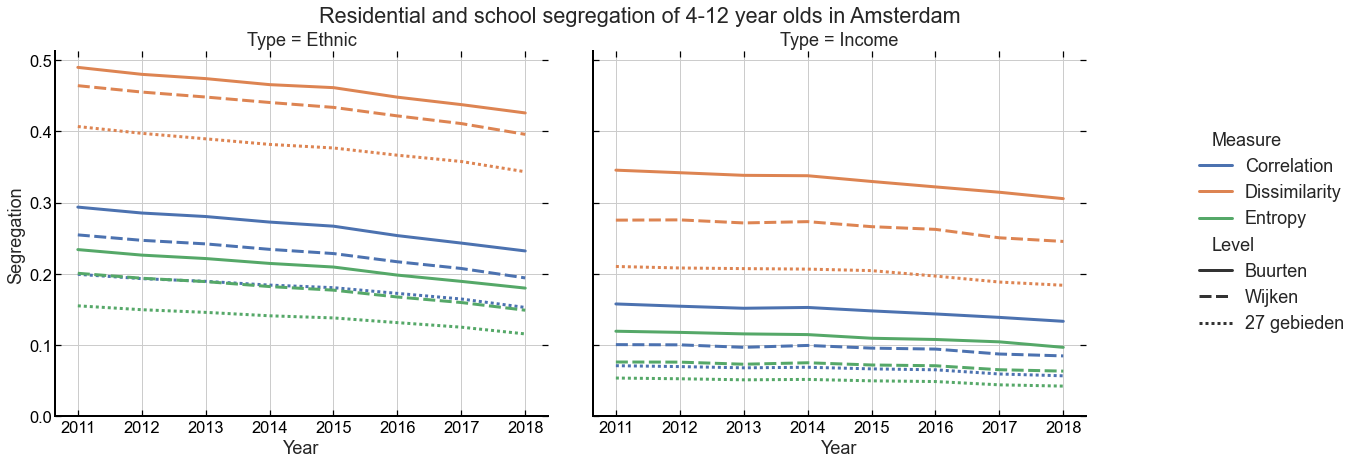

In [16]:
plot = sns.relplot(
    data=res_seg_data, x="Year", y="Segregation",
    col="Type", hue="Measure", style="Level",
    kind="line"
)
plot.figure.set_size_inches(20,7)
_ = plt.ylim((0,None))
_ = plot.fig.suptitle('Residential and school segregation of 4-12 year olds in Amsterdam')